In [ ]:
!pip install pandas
!pip install requests
!pip install matplotlib
!pip install yfinance

# DATA

In [26]:
import pandas as pd
import yfinance as yf
import datetime as dt


def yfinance_data(ticker, interval='1d', years_data=7):

    """
    DATES EXAMPLE = '2022-10-06'
    """

    try:

        start = dt.datetime.today() - dt.timedelta(365*years_data)
        start = start.strftime('%Y-%m-%d')

        end = dt.datetime.today() + dt.timedelta(1)
        end = end.strftime('%Y-%m-%d')

        data = yf.download(tickers=ticker, interval=interval, auto_adjust=True, start=start, end=end)

        data.index = pd.to_datetime(data.index)
        data = data.tz_localize(None)

    except:
        data = pd.DataFrame()

    return data


def data_etfs(tickers, interval='1d', years_data=3):

    dfs = []
    for ticker in tickers:

        print(f'Descargando data {ticker}')

        data = yfinance_data(ticker=ticker, interval=interval, years_data=years_data)

        if data.empty:
            print(f'Error con ticker {ticker}')
            continue

        data_filter = pd.DataFrame()
        data_filter[ticker] = data['Close']

        dfs.append(data_filter)

    data_all = pd.concat(dfs, axis=1)

    return data_all

# INDICADORES

In [16]:
import pandas as pd


def add_sma(df, column_name, k):
    if k == 0:
        return df[column_name]
    else:
        return df[column_name].rolling(k).mean()


def add_cruce_sma(df_copy, column_name, k1, k2):
    df = df_copy.copy()
    if k1 == 0:
        df['media1'] = df[column_name]

    else:
        df['media1'] = add_sma(df, column_name, k1)
    df['media2'] = add_sma(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['media1', 'media2'], axis=1, inplace=True)

    return df


def add_ema(df, column_name, k):
    if k == 0:
        return df[column_name]
    else:
        return df[column_name].ewm(span=k, adjust=False).mean()


def add_cruce_ema(df_copy, column_name, k1, k2):
    df = df_copy.copy()

    if k1 == 0:
        df['media1'] = df[column_name]
    else:
        df['media1'] = add_ema(df, column_name, k1)
    df['media2'] = add_ema(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['media1', 'media2'], axis=1, inplace=True)

    return df


def add_dema(df_copy, column_name, k):
    """
    DEMA = 2 * EMA1 - 2 * EMA2
    EMA 1 = EMA
    EMA 2 = EMA de EMA1
    """
    df = df_copy.copy()

    if k == 0:
        return df[column_name]
    else:
        df['media1'] = add_ema(df, column_name, k)
        df['ema_media1'] = add_ema(df, 'media1', k)
        return 2 * df['media1'] - df['ema_media1']


def add_cruce_dema(df_copy, column_name, k1, k2):
    df = df_copy.copy()
    if k1 == 0:
        df['media1'] = df[column_name]
    else:
        df['media1'] = add_dema(df, column_name, k1)

    df['media2'] = add_dema(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['dema1', 'dema2'], axis=1, inplace=True)

    return df


def add_tema(df_copy, column_name, k):
    """
    TEMA = 3 * EMA1 - 3 * EMA2 + EMA3
    EMA 1 = EMA
    EMA 2 = EMA de EMA1
    EMA 3 = EMA de EMA2
    """
    df = df_copy.copy()

    if k == 0:
        return df[column_name]
    else:
        df['media1'] = df[column_name].ewm(span=k, adjust=False).mean()
        df['ema_media1'] = df['media1'].ewm(span=k, adjust=False).mean()
        df['ema_ema_media1'] = df['ema_media1'].ewm(span=k, adjust=False).mean()
        return 3 * df['media1'] - 3 * df['ema_media1'] + df['ema_ema_media1']


def add_cruce_tema(df_copy, column_name, k1, k2):
    df = df_copy.copy()
    if k1 == 0:
        df['media1'] = df[column_name]
    else:
        df['media1'] = add_tema(df, column_name, k1)

    df['media2'] = add_tema(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['tema1', 'tema2'], axis=1, inplace=True)

    return df


def add_wma(df_copy, column_name, k):
    """
    PESO = 1/n
    WMA = Sumatoria de los Precio z * i/n
    Siendo i partiendo de 1 a n
    Siendo z partiendo del mas alejado hacia el mas cercano
    """
    df = df_copy.copy()

    if k == 0:
        return df[column_name]
    else:
        return df[column_name].rolling(k).apply(lambda x: x[::-1].cumsum().sum() * 2 / k / (k + 1))


def add_cruce_wma(df_copy, column_name, k1, k2):
    df = df_copy.copy()
    if k1 == 0:
        df['media1'] = df[column_name]
    else:
        df['media1'] = add_wma(df, column_name, k1)

    df['media2'] = add_wma(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['media1', 'media2'], axis=1, inplace=True)

    return df


def add_hma(df_copy, column_name, k):
    """
    HMA = WMA (RAW WMA periodo = sqrt(n)
    RAW WMA = 2 * WMA2 - WMA1
    WMA1 = WMA n
    WMA2 = (WMA n/2) * 2
    """
    df = df_copy.copy()
    k_a = round(k / 2)

    if k == 0:
        return df[column_name]
    else:
        df['media1'] = df[column_name].rolling(k).apply(lambda x: x[::-1].cumsum().sum() * 2 / k / (k + 1))
        df['media1_edit'] = df[column_name].rolling(k_a).apply(lambda x: x[::-1].cumsum().sum() * 2 / k_a / (k_a + 1))
        df['a1'] = df['media1_edit'] * 2 - df['media1']
        k_s = round(k ** 0.5)
        return df['a1'].rolling(k_s).apply(lambda x: x[::-1].cumsum().sum() * 2 / k_s / (k_s + 1))


def add_cruce_hma(df_copy, column_name, k1, k2):
    df = df_copy.copy()

    if k1 == 0:
        df['media1'] = df[column_name]
    else:
        df['media1'] = add_hma(df, column_name, k1)

    df['media2'] = add_hma(df, column_name, k2)

    df['cruce'] = df['media1'] / df['media2'] - 1
    # df.drop(['hma1', 'hma2'], axis=1, inplace=True)

    return df


def add_indicator_cruce(df, indicador, k1, k2):
    for activo in df.columns:

        if indicador == 'SMA':
            df = add_cruce_sma(df, activo, k1, k2)

        elif indicador == 'EMA':
            df = add_cruce_ema(df, activo, k1, k2)

        elif indicador == 'WMA':
            df = add_cruce_wma(df, activo, k1, k2)

        elif indicador == 'DEMA':
            df = add_cruce_dema(df, activo, k1, k2)

        elif indicador == 'TEMA':
            df = add_cruce_tema(df, activo, k1, k2)

        elif indicador == 'HMA':
            df = add_cruce_hma(df, activo, k1, k2)

        else:
            df = pd.DataFrame()

    df.dropna(inplace=True)

    return df

# POSICIONES

In [17]:
import pandas as pd
import numpy as np


def add_state(df):

    name = 'cruce'

    df['estado'] = np.where(df[name] > 0, 'LONG', 'SHORT')

    return df


def operations(df):

    df['operacion'] = np.where((df['estado'] == 'LONG') & (df['estado'].shift() == 'SHORT'), 'LONG',
                               np.where((df['estado'] == 'SHORT') & (df['estado'].shift() == 'LONG'), 'SHORT',
                                        ''))

    filtro_operaciones = df.loc[df['operacion'] != '']

    return filtro_operaciones


def add_trades(df, side='both'):

    filtro_trades = pd.DataFrame()

    filtro_trades['price_open'] = df.close
    filtro_trades['price_close'] = df.close.shift(-1)
    filtro_trades['side'] = df.operacion
    filtro_trades['date_init'] = df.index
    filtro_trades['date_fin'] = filtro_trades['date_init'].shift(-1)
    filtro_trades = filtro_trades.iloc[:-1]
    filtro_trades.reset_index(inplace=True)
    filtro_trades.drop(['Date'], axis=1, inplace=True)

    if side != 'BOTH':
        filtro_trades = filtro_trades.loc[filtro_trades['side'] == side]

    return filtro_trades


def add_results(df):

    df['dias'] = df['date_fin'] - df['date_init']

    df['rdo'] = np.where(df['side'] == 'LONG', df['price_close'] / df['price_open'] - 1,
                         df['price_open'] / df['price_close'] - 1) * 100

    df['rdo_acu'] = ((df['rdo'] / 100 + 1).cumprod() - 1) * 100

    count_operations = df['rdo'].groupby([df['rdo'] > 0]).count().to_dict()
    n_ganadores = count_operations[True]
    n_perdedores = count_operations[False]

    per_n_ganadores = (n_ganadores / (n_perdedores + n_ganadores)) * 100
    per_n_perdedores = (n_perdedores / (n_perdedores + n_ganadores)) * 100

    per_operations = df['rdo'].groupby([df['rdo'] > 0]).mean().to_dict()
    per_ganadores = per_operations[True]
    per_perdedores = per_operations[False]

    last_data = df.iloc[-1].to_dict()

    result = {}
    result['resultadodo_acumulado'] = last_data['rdo_acu']
    result['operaciones_totales'] = df.index[-1] + 1
    result['n_ganadores'] = n_ganadores
    result['n_perdedores'] = n_perdedores
    result['porcentaje_ganadores'] = per_n_ganadores
    result['porcentaje_perdedores'] = per_n_perdedores
    result['resultado_promedio_ganadores'] = per_ganadores
    result['resultado_promedio_perdedores'] = per_perdedores

    return result

# GRAFICO

In [18]:
import matplotlib.pyplot as plt


def plot_activo_trade(data):

    df_copy = data.copy()
    df_copy['compras'] = (data.close * 0.90).loc[data.operacion == 'LONG']
    df_copy['ventas'] = (data.close * 1.10).loc[data.operacion == 'SHORT']


    plt.figure(figsize=(20, 6))

    plt.plot(data.close, color='black')
    plt.plot(data.media1)
    plt.plot(data.media2)
    plt.legend(['Precio', 'Media Rapida', 'Media Lenta'])

    plt.plot(data.index, df_copy.compras, '^', markersize=10, c='grey')
    plt.plot(data.index, df_copy.ventas, 'v', markersize=10, c='grey')

    plt.grid(which='major', axis='y', color='black', lw=1, alpha=0.15)
    plt.suptitle('Estrategia Cruce Medias', y=0.92)

    plt.savefig('grafico_estrategia')

    plt.show()


def grafico_best(data, resultados, k1, k2):
    indicador = resultados.iloc[0, 8]

    data_indicadores = add_indicator_cruce(data, indicador, k1=k1, k2=k2)
    data_estados = add_state(data_indicadores)
    operaciones = operations(data_estados)

    plot_activo_trade(data_indicadores)

# MAIN

In [19]:
import pandas as pd
pd.options.display.max_columns = 10

def run(tickers, indicadores, m_rapida, m_lenta, side):

    resultados = []

    data = data_etfs(tickers)
    data.columns = ['close']

    for indicador in indicadores:

        # AGREGO INDICADORES
        data_indicadores = add_indicator_cruce(data, indicador, k1=m_rapida, k2=m_lenta)

        # AGREGO ESTADOS
        data_estados = add_state(data_indicadores)

        # AGREGO OPERACIONES
        operaciones = operations(data_estados)

        # ARMO LOS TRADES
        trades = add_trades(operaciones, side)

        # RESULTADOS
        resultado = add_results(trades)
        resultado['indicador'] = indicador
        resultado['medias'] = str(m_rapida) + '_' + str(m_lenta)

        resultados.append(resultado)

    resultados = pd.DataFrame(resultados)
    resultados.sort_values(by='resultadodo_acumulado', axis=0, ascending=False, inplace=True)
    print(resultados)
    resultados.to_excel('resultados.xlsx')

    # PLOTEO
    grafico_best(data, resultados, m_rapida, m_lenta)

# RUN!

Descargando data SPY
[*********************100%***********************]  1 of 1 completed
   resultadodo_acumulado  operaciones_totales  n_ganadores  n_perdedores  \
5              47.448080                   37           17            20   
4              22.005207                   13            5             8   
0               9.359659                   11            4             7   
1               8.329663                   14            3            11   
3               7.241752                   46           14            32   
2             -23.162739                   30            7            23   

   porcentaje_ganadores  porcentaje_perdedores  resultado_promedio_ganadores  \
5             45.945946              54.054054                      5.630380   
4             38.461538              61.538462                     11.208955   
0             36.363636              63.636364                     12.118132   
1             21.428571              78.571429           

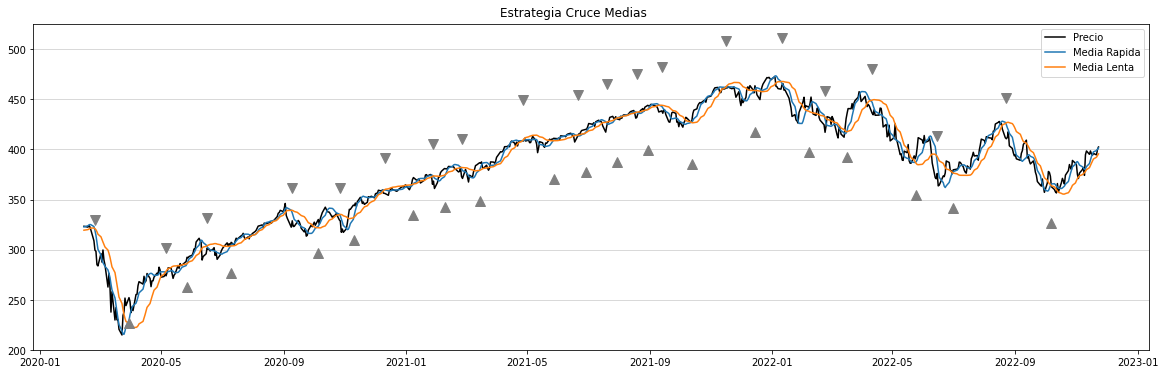

In [27]:
if __name__ == '__main__':
    tickers = ['SPY']
    indicadores = ['SMA', 'EMA', 'DEMA', 'TEMA', 'WMA', 'HMA']
    m_rapida = 20
    m_lenta = 50
    side = 'BOTH'

    run(tickers=tickers, indicadores=indicadores, m_rapida=m_rapida, m_lenta=m_lenta, side=side)